# **Quora Duplicate Question Pair Identification**

For the purpose of this project, let me put myself in the shoes of a Data Scientist at Quora for the sake of this project. Keeping in mind the huge potential of this platform to share knowledge, with more than 100,000,000 visitors every month who are interested in answering a huge number of questions, duplication of similar questions is an important question. This will make the user experience more streamlined, bringing the answer faster to the user and reducing load on the contributors—response to frequent repeated questions. This project aims at developing a sophisticated model which can easily identify duplicate question pairs using advanced NLP techniques and machine learning algorithms.

## **Required Imports**

In [31]:
#Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Text Processing and Feature Extraction
import string
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.metrics import edit_distance
from gensim.models import Word2Vec
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Machine Learning Models and Evaluation Metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    log_loss, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

#TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Lambda, Dense, Dropout, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization, Bidirectional, Layer
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

#Transformers for BERT and other models
from transformers import (
    BertTokenizer, TFBertModel, DistilBertConfig, TFDistilBertModel,
    BertConfig, TFRobertaModel, AutoTokenizer, DataCollatorWithPadding, TFAutoModel
)

#Ignoring Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Code to Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Acquisition, Analysis, and Processing**

The dataset used for this project is sourced from Quora and was made available on Kaggle as part of a competition. The primary goal of the competition was to predict which of the provided pairs of questions have the same intent. The dataset is comprised of genuine questions from Quora, supplemented with computer-generated pairs in the test set to prevent cheating.

Data Fields:
- id: The unique identifier for each question pair in the training set.
- qid1, qid2: Unique identifiers for each question.
- question1, question2: The full text of each question.
- is_duplicate: The target variable, set to 1 if the questions have essentially the same meaning, and 0 otherwise.


In [3]:
#Read the training data
train_quora_data = pd.read_csv('/content/drive/MyDrive/CS6120_NLP_Uzair/Project/train.csv.zip')
train_quora_data.shape

(404290, 6)

In [4]:
#Visualize the data
train_quora_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
#Info of the data
train_quora_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
#Checking the presence of null values in the data
train_quora_data.isna().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [7]:
#Checking the rows where null values are present
train_quora_data[train_quora_data.isna().any(axis=1)].head()

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


Given the dataset size of 404,290 rows, the presence of only 3 rows with missing values is negligible. Imputing these values would introduce unnecessary complexity and potential bias, especially since the label for these rows is 0. Therefore, it is more efficient and methodologically sound to simply drop these rows. This approach ensures data integrity and simplifies preprocessing without significantly impacting the model's performance.

In [8]:
#Removing the rows containing null values
train_quora_data.dropna(inplace=True)

#Verify that there are no more missing values
print("Missing values in the dataset after dropping:")
print(train_quora_data.isnull().sum())
print("New shape of the dataset:", train_quora_data.shape)

Missing values in the dataset after dropping:
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64
New shape of the dataset: (404287, 6)


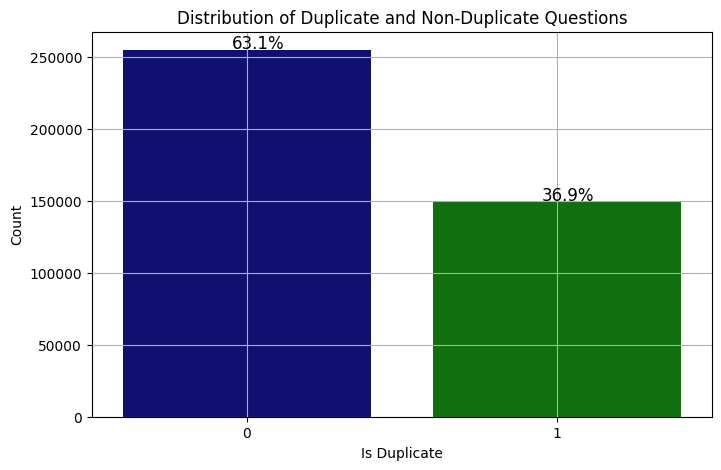

In [9]:
#Class Distribution
plt.figure(figsize=(8,5))
colors = ['navy', 'green']
ax = sns.countplot(x='is_duplicate', data=train_quora_data, palette=colors)
total = len(train_quora_data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + 1000
    ax.annotate(percentage, (x, y), fontsize=12, color='black')

plt.title('Distribution of Duplicate and Non-Duplicate Questions')
plt.xlabel('Is Duplicate')
plt.ylabel('Count')
plt.grid(True)
plt.show()

**Inference:**

The distribution plot reveals a slight imbalance in the dataset, with approximately 63.1% of the questions labeled as non-duplicates and 36.9% labeled as duplicates. However, this imbalance reflects the typical distribution of real-world data. Therefore, for the initial phase of the project, I will not modify the class distribution. If necessary, I will consider applying class weighting techniques later in the modeling process to address any potential issues arising from this small imbalance.

In [10]:
#Statistics on question ids
qids = pd.Series(train_quora_data['qid1'].to_list() + train_quora_data['qid2'].to_list())
num_unique_questions = len(np.unique(qids))
non_unique_questions = np.sum(qids.value_counts() > 1)
percentage_non_unique_questions = ( non_unique_questions / num_unique_questions ) * 100

print("Statistics on Question IDs:")
print(f"Number of Unique Questions: {num_unique_questions}")
print(f"Number of Non-Unique Questions: {non_unique_questions}")
print(f"Percentage of Non-Unique Questions: {percentage_non_unique_questions:.2f}%")
print(f"Maximum Times a Question Got Repeated: {qids.value_counts().iloc[0]}")

Statistics on Question IDs:
Number of Unique Questions: 537929
Number of Non-Unique Questions: 111778
Percentage of Non-Unique Questions: 20.78%
Maximum Times a Question Got Repeated: 157


**Inference:**

The significant number of non-unique questions and there high repetition frequency highlight the importance of implementing advanced NLP and machine learning techniques for semantic duplication detection. Addressing these issue will enhance the user experience by reducing redundancy, ensuring quicker access to information, and alleviating the load on contributors who frequently encounter repeated questions.

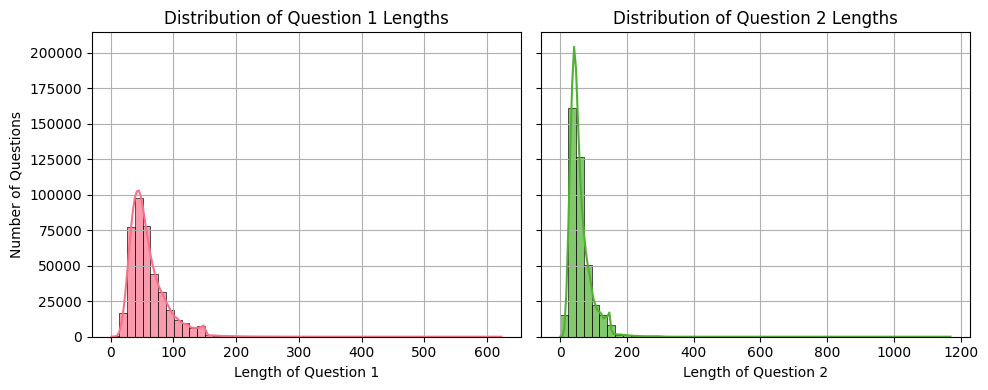

In [11]:
#Question Length Analysis
#Calculating the lengths of questions
train_quora_data['q1_len'] = train_quora_data['question1'].apply(lambda x: len(str(x)))
train_quora_data['q2_len'] = train_quora_data['question2'].apply(lambda x: len(str(x)))

palette = sns.color_palette("husl", 3)
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

#Plot for Question 1
sns.histplot(train_quora_data['q1_len'], bins=50, kde=True, ax=axs[0], color=palette[0], alpha=0.7)
axs[0].set_title('Distribution of Question 1 Lengths')
axs[0].set_xlabel('Length of Question 1')
axs[0].set_ylabel('Number of Questions')
axs[0].grid(True)

#Plot for Question 2
sns.histplot(train_quora_data['q2_len'], bins=50, kde=True, ax=axs[1], color=palette[1], alpha=0.7)
axs[1].set_title('Distribution of Question 2 Lengths')
axs[1].set_xlabel('Length of Question 2')
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Inference:**

The Kernel Density Estimate (KDE) plots for 'question1' and 'question2' reveal a striking similarity in their length distributions, with 'question1' ranging from 0 to 150 and 'question2' from 0 to 180. Both distributions exhibit a pronounced peak within the initial two bins, indicating a concentration of questions in the shorter length range. These uniformity in distribution suggests a prevalent trend towards concise queries, with a significant proportion of questions being relatively brief across both datasets.

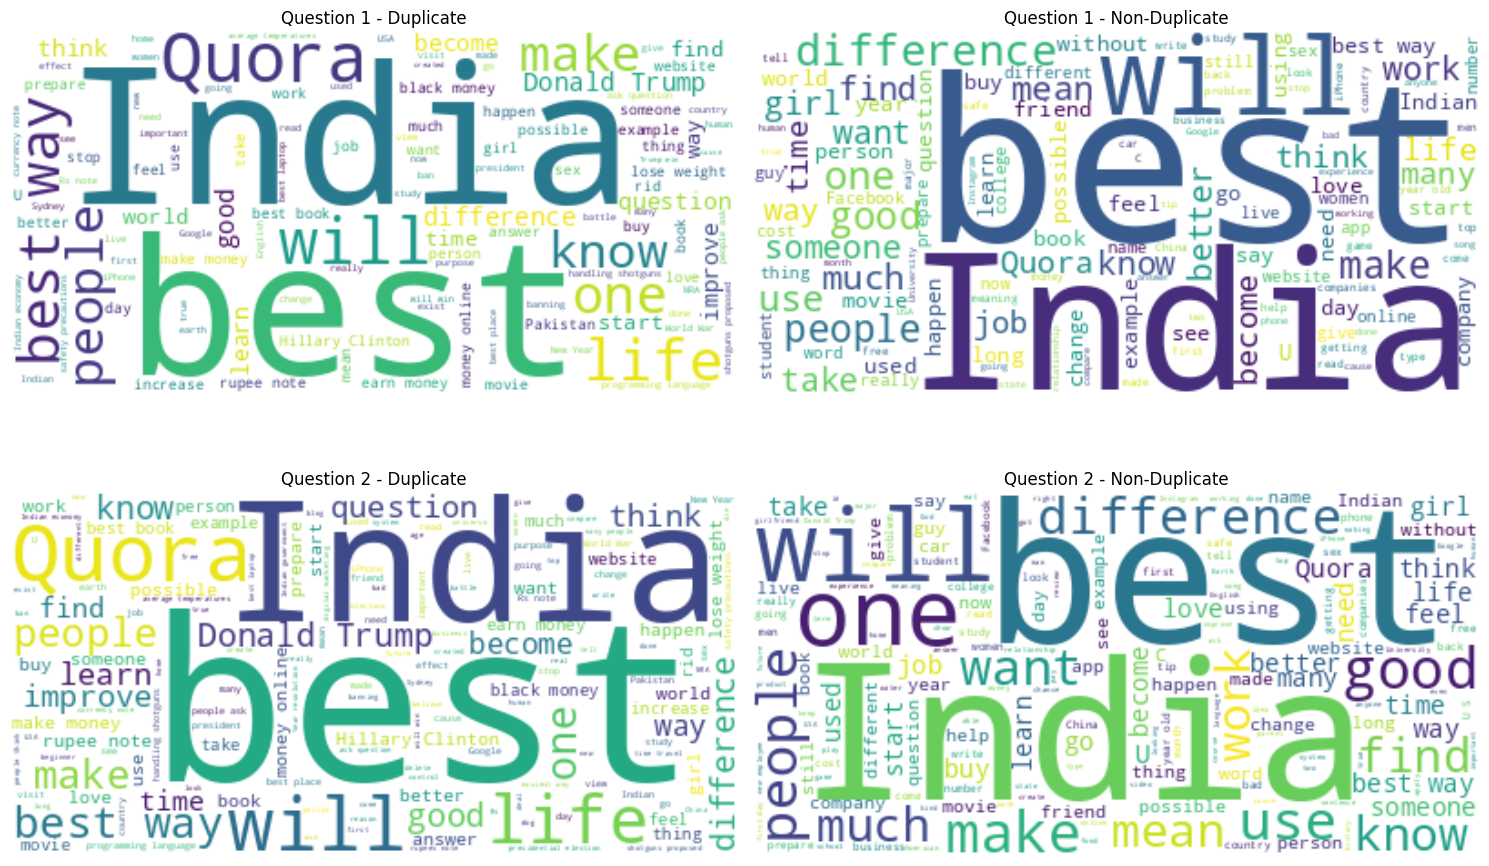

In [12]:
#Defining the parameters for the WordCloud
wordcloud_params = {
    'width': 400,
    'height': 200,
    'background_color': 'white'
}

#Generate word clouds for each category
wordcloud_q1_duplicate = WordCloud(**wordcloud_params).generate(' '.join(train_quora_data[train_quora_data['is_duplicate'] == 1]['question1'].astype(str)))
wordcloud_q1_non_duplicate = WordCloud(**wordcloud_params).generate(' '.join(train_quora_data[train_quora_data['is_duplicate'] == 0]['question1'].astype(str)))
wordcloud_q2_duplicate = WordCloud(**wordcloud_params).generate(' '.join(train_quora_data[train_quora_data['is_duplicate'] == 1]['question2'].astype(str)))
wordcloud_q2_non_duplicate = WordCloud(**wordcloud_params).generate(' '.join(train_quora_data[train_quora_data['is_duplicate'] == 0]['question2'].astype(str)))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#Plot for question1 - duplicate
axes[0, 0].imshow(wordcloud_q1_duplicate, interpolation='bilinear')
axes[0, 0].set_title('Question 1 - Duplicate')
axes[0, 0].axis('off')

#Plot for question1 - non-duplicate
axes[0, 1].imshow(wordcloud_q1_non_duplicate, interpolation='bilinear')
axes[0, 1].set_title('Question 1 - Non-Duplicate')
axes[0, 1].axis('off')

#Plot for question2 - duplicate
axes[1, 0].imshow(wordcloud_q2_duplicate, interpolation='bilinear')
axes[1, 0].set_title('Question 2 - Duplicate')
axes[1, 0].axis('off')

#Plot for question2 - non-duplicate
axes[1, 1].imshow(wordcloud_q2_non_duplicate, interpolation='bilinear')
axes[1, 1].set_title('Question 2 - Non-Duplicate')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

**Inference:**

The examination of the word clouds reveals notable similarities in the vocabulary used across both duplicate and non-duplicate questions, with frequent terms such as "India", "Best", "Quora", "Will", "Donald Trump" and "Life" prominently featured. These consistency in vocabulary suggests uniformity in the language employed in the questions. Furthermore, the text appears to be relatively clean, as the incidence of potentially problematic words is low. These overall cleanliness of the dataset simplifies text analysis process.

In [13]:
#Top Bigram Analysis
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')

#Top Bigrams in Question 1
bigrams_q1 = vectorizer.fit_transform(train_quora_data['question1'])
feature_names_q1 = vectorizer.get_feature_names_out()
top_bigrams_q1 = pd.DataFrame(bigrams_q1.sum(axis=0).tolist()[0], index=feature_names_q1, columns=['Count']).sort_values(by='Count', ascending=False).head(20)

#Top Bigrams in Question 2
bigrams_q2 = vectorizer.fit_transform(train_quora_data['question2'])
feature_names_q2 = vectorizer.get_feature_names_out()
top_bigrams_q2 = pd.DataFrame(bigrams_q2.sum(axis=0).tolist()[0], index=feature_names_q2, columns=['Count']).sort_values(by='Count', ascending=False).head(20)

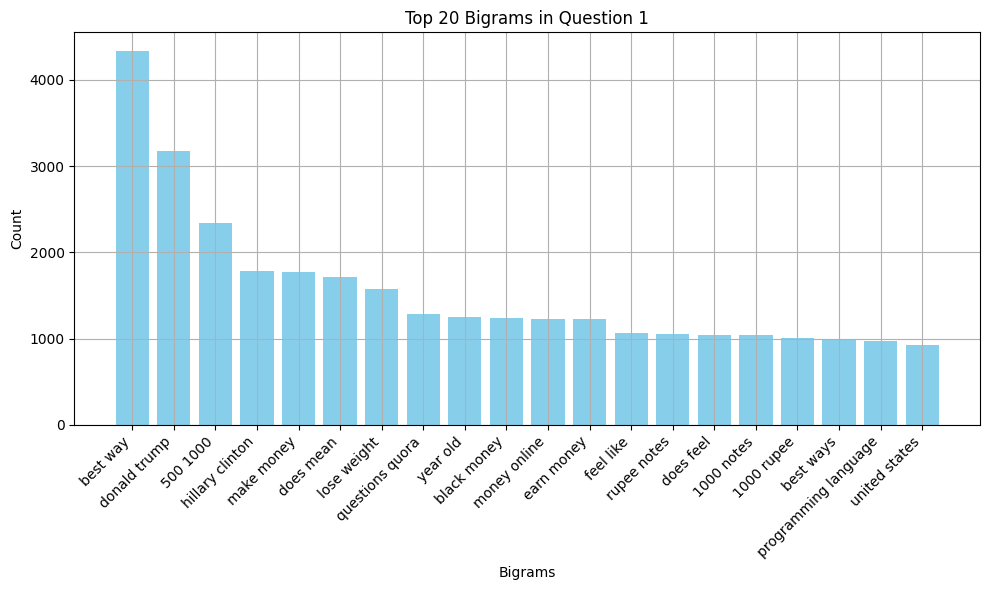

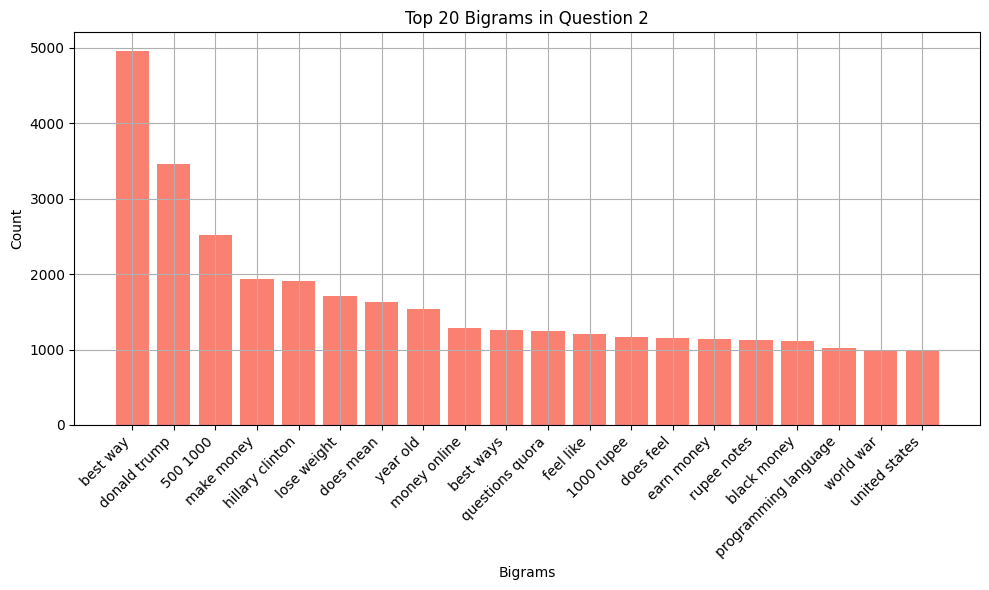

In [14]:
#Plot histograms for top bigrams in Question 1
plt.figure(figsize=(10, 6))
plt.bar(top_bigrams_q1.index, top_bigrams_q1['Count'], color='skyblue')
plt.title('Top 20 Bigrams in Question 1')
plt.xlabel('Bigrams')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

#Plot histograms for top bigrams in Question 2
plt.figure(figsize=(10, 6))
plt.bar(top_bigrams_q2.index, top_bigrams_q2['Count'], color='salmon')
plt.title('Top 20 Bigrams in Question 2')
plt.xlabel('Bigrams')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

**Inference:**

In analyzing the top 20 bigrams within question1 and question2, a  consistency is observed, with the same five bigrams appearing in identical order across both sets. These repeating sequence shows a common linguistic structure prevalent in the questions. Despite the overall alignment in bigram patterns, subtle frequency variations exist. Certain bigrams occur more frequently, with some appearing up to 5000 times, while others range between 1000 and 5000 occurrences. These differences in frequency may reflect distinctions in how specific phrases or concepts are framed. These analysis underscores a high degree of textual similarity between the questions and offers valuable insights into the recurring linguistic patterns within the dataset.

The appearance of political figures like "Donald Trump" and "Hillary Clinton" suggests that political topics are a significant portion of the questions. These can be an important insight for understanding user interests and the nature of discussions on Quora.

Bigrams like "make money," "lose weight," and "earn money" indicate a strong focus on personal finance and self-improvement topics. This aligns with common themes on platforms like Quora, where users seek advice and information on these subjects.

## **Machine Learning Approach**

In [12]:
#Method to evaluate the model
def evaluate_binary_model(model, model_name, train_combined, y_train, test_combined, y_test):
    """
    Evaluate a binary classification model and print detailed metrics and plots.

    Args:
    - model: The trained model to evaluate.
    - model_name (str): The name of the model (for reporting purposes).
    - train_combined (array-like): Feature matrix for the training set.
    - y_train (array-like): True labels for the training set.
    - test_combined (array-like): Feature matrix for the test set.
    - y_test (array-like): True labels for the test set.
    """

    def calculate_metrics(predictions, probabilities, y_true):
        """
        Calculate key evaluation metrics for a binary classification model.

        Args:
        - predictions (array-like): Predicted class labels.
        - probabilities (array-like): Predicted probabilities for the positive class.
        - y_true (array-like): True class labels.

        Returns:
        - accuracy (float): Accuracy of the model.
        - precision (float): Precision of the model.
        - recall (float): Recall of the model.
        - f1 (float): F1 score of the model.
        - roc_auc (float): ROC AUC score of the model.
        """

        accuracy = accuracy_score(y_true, predictions)
        precision = precision_score(y_true, predictions)
        recall = recall_score(y_true, predictions)
        f1 = f1_score(y_true, predictions)
        roc_auc = roc_auc_score(y_true, probabilities)
        return accuracy, precision, recall, f1, roc_auc

    def print_metrics(accuracy, precision, recall, f1, roc_auc, dataset_name):
        """
        Print evaluation metrics for a specific dataset (train/test).

        Args:
        - accuracy (float): Accuracy of the model.
        - precision (float): Precision of the model.
        - recall (float): Recall of the model.
        - f1 (float): F1 score of the model.
        - roc_auc (float): ROC AUC score of the model.
        - dataset_name (str): The name of the dataset (e.g., "Train", "Test").
        """

        print(f"\n{dataset_name} Set Metrics:")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("ROC AUC:", roc_auc)

    def plot_confusion_matrix(y_true, predictions):
        """
        Plot the confusion matrix as a heatmap.

        Args:
        - y_true (array-like): True class labels.
        - predictions (array-like): Predicted class labels.
        """

        conf_matrix = confusion_matrix(y_true, predictions)
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
                    xticklabels=['Class 0', 'Class 1'],
                    yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def plot_roc_curve(y_true, probabilities):
        """
        Plot the ROC curve and calculate the AUC score.

        Args:
        - y_true (array-like): True class labels.
        - probabilities (array-like): Predicted probabilities for the positive class.
        """

        fpr, tpr, _ = roc_curve(y_true, probabilities)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def print_classification_report(y_true, predictions):
        """
        Print a detailed classification report, including precision, recall, and F1 score.

        Args:
        - y_true (array-like): True class labels.
        - predictions (array-like): Predicted class labels.
        """

        class_report = classification_report(y_true, predictions,
                                             target_names=['Class 0', 'Class 1'])
        print("Classification Report:\n", class_report)


    print("--- Results of", model_name, "---")

    #Training set evaluation
    train_predictions = model.predict(train_combined)
    train_probabilities = model.predict_proba(train_combined)[:, 1]
    train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = calculate_metrics(train_predictions, train_probabilities, y_train)
    print_metrics(train_accuracy, train_precision, train_recall, train_f1, train_roc_auc, "Train")

    #Test set evaluation
    test_predictions = model.predict(test_combined)
    test_probabilities = model.predict_proba(test_combined)[:, 1]
    test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = calculate_metrics(test_predictions, test_probabilities, y_test)
    print_metrics(test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, "Test")

    #Plotting and printing
    plot_confusion_matrix(y_test, test_predictions)
    plot_roc_curve(y_test, test_probabilities)
    print_classification_report(y_test, test_predictions)

### **Text Preprocessing**

In [1]:
def preprocess_text(text):
    """
    Preprocess the input text by converting to lowercase, removing punctuation, and removing stop words.

    Args:
    - text (str): The input text string that needs to be preprocessed.

    Returns:
    - str: The preprocessed text with lowercase characters, no punctuation, and no stop words.
    """
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [14]:
#Apply preprocessing to question1 and question2
train_quora_data['question1_processed'] = train_quora_data['question1'].apply(preprocess_text)
train_quora_data['question2_processed'] = train_quora_data['question2'].apply(preprocess_text)

#Visualize the data
train_quora_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,question1_processed,question2_processed
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,step step guide invest share market india,step step guide invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,increase speed internet connection using vpn,internet speed increased hacking dns
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,mentally lonely solve,find remainder math2324math divided 2423
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,one dissolve water quikly sugar salt methane c...,fish would survive salt water


### **Train Test Split**

In [15]:
#Extracting X (input features to model) and y (label)
X = train_quora_data[['question1_processed', 'question2_processed']]
y = train_quora_data['is_duplicate']

#Combining 'question1' and 'question2' into a single string for each row
X['combined_questions'] = X['question1_processed'].astype(str) + ' ' + X['question2_processed'].astype(str)

#Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X['combined_questions'], y, test_size=0.2, random_state=42)

The reason for combining the questions before performing TF-IDF is based on insights gained from an ablation study. The study revealed that when the two questions are combined into a single text input before vectorization, the resulting TF-IDF representation is more effective. This approach allows the vectorizer to capture the contextual relationships between the paired questions, leading to a more informative and nuanced representation of the text, which ultimately enhances the model's performance.

### **TF-IDF Vectorization**

In [16]:
#TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#Verifying that the shapes match
print(X_train_tfidf.shape, '  ', len(X_train))
print(X_test_tfidf.shape, '  ', len(X_test))

(323429, 97149)    323429
(80858, 97149)    80858


#### **Logistic Regression**

--- Results of Logistic Regression ---

Train Set Metrics:
Accuracy: 0.7782326260168383
Precision: 0.7660120222601403
Recall: 0.5751103147424036
F1 Score: 0.6569742417431061
ROC AUC: 0.8430920992720636

Test Set Metrics:
Accuracy: 0.7538400652996612
Precision: 0.7232616713142035
Recall: 0.5390520246714937
F1 Score: 0.6177159758767717
ROC AUC: 0.8063142893242305


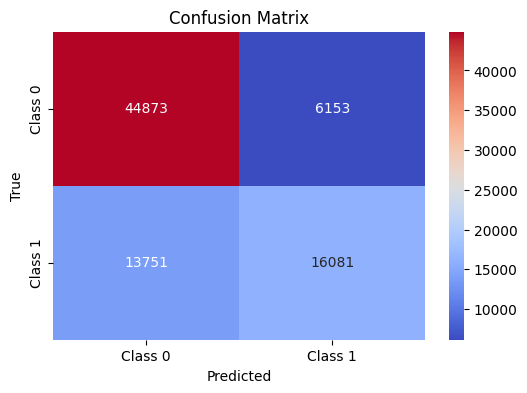

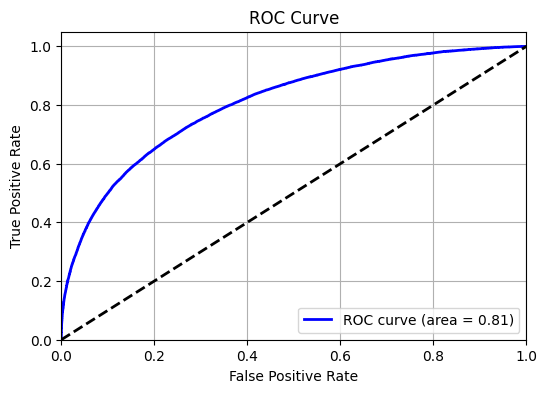

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.77      0.88      0.82     51026
     Class 1       0.72      0.54      0.62     29832

    accuracy                           0.75     80858
   macro avg       0.74      0.71      0.72     80858
weighted avg       0.75      0.75      0.74     80858



In [17]:
#Logistic Regression
classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

#Evaluate the model
evaluate_binary_model(classifier, "Logistic Regression", X_train_tfidf, y_train, X_test_tfidf, y_test)

**Inferences:**

The Logistic Regression model, utilizing TF-IDF features, has established a solid baseline with an accuracy of 75.38% on the test set. Precision for the positive class is 72.33%, suggesting the model is relatively confident in its predictions, though the recall at 53.91% indicates that a significant portion of actual positives is being overlooked. The F1 score of 61.77% reflects a moderate balance between precision and recall, while the ROC AUC score of 0.81 demonstrates the model's reasonable ability to distinguish between classes. The confusion matrix reveals that the model correctly identifies a substantial number of true negatives and true positives but also highlights areas for improvement in reducing false negatives. Overall, this model sets a benchmark for further development, where future iterations can focus on improving recall and overall model robustness through more advanced techniques and tuning.

#### **XGBClassifier**

In [18]:
#XGBoost Classifier
classifier = XGBClassifier(verbose=1)
classifier.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

--- Results of XGBoost Classifier ---

Train Set Metrics:
Accuracy: 0.7467945051309561
Precision: 0.7905565446241969
Recall: 0.4275774296455694
F1 Score: 0.5549867953441362
ROC AUC: 0.8135938008853774

Test Set Metrics:
Accuracy: 0.7369215167330382
Precision: 0.76753344168021
Recall: 0.41160498793242156
F1 Score: 0.5358498799912721
ROC AUC: 0.7935740352404171


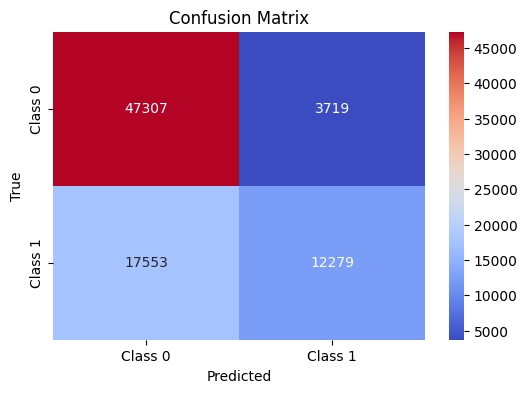

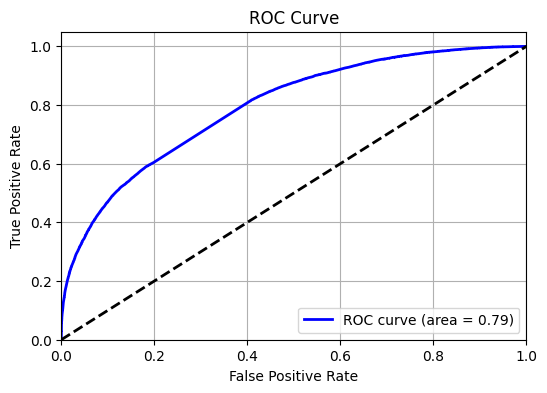

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.73      0.93      0.82     51026
     Class 1       0.77      0.41      0.54     29832

    accuracy                           0.74     80858
   macro avg       0.75      0.67      0.68     80858
weighted avg       0.74      0.74      0.71     80858



In [19]:
#Evaluating XGBoost Classifier
evaluate_binary_model(classifier, "XGBoost Classifier", X_train_tfidf, y_train, X_test_tfidf, y_test)

**Inferences:**

The XGBoost Classifier, trained using TF-IDF features, gives an accuracy of 73.69% on test set, which is slightly lower than the performance of our previous Logistic Regression model. While the model achieves a high precision of 76.70% for the positive class, its recall is notably lower at 41.13%, resulting in an F1 score of 53.58%. This indicates that the model is effective at minimizing false positives but struggles to capture a significant portion of true positives. The ROC AUC score of 0.79, while decent, still suggest room for improvement in distinguishing between class. The confusion matrix further highlight these with a substantial number of false negatives (17,553), leading to the underperformance in recall. Given this observations, it is evident that to enhance the model's ability to generalize, particularly in identifying positive cases, more complex deep learning approache should be used. These will likely improve both recall and overall model robustness.

## **Deep Learning Approach**

#### **Text Preprocessing**

In [10]:
#Method to preprocess text: convert to lowercase and remove punctuation
def preprocess_text(text):
    """
    Preprocess the input text by converting it to lowercase and removing punctuation.

    Args:
    - text (str): The input text string that needs to be preprocessed.

    Returns:
    - str: The preprocessed text with lowercase characters and no punctuation.
    """

    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

 Compared to above here, the stop words are retained because they provide essential contextual information that helps the model learn the relationships between words. Removing stop words could disrupt the sentence structure and diminish the quality of the learned embeddings, as these common words play a crucial role in capturing the syntactic and semantic nuances of language.

In [11]:
#Apply preprocessing to question1 and question2
train_quora_data['question1_processed'] = train_quora_data['question1'].apply(preprocess_text)
train_quora_data['question2_processed'] = train_quora_data['question2'].apply(preprocess_text)

#Visualize the data
train_quora_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_processed,question2_processed
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water


### **Word2Vec**

In [21]:
#Extracting X (input features to model) and y (label)
X = train_quora_data[['question1_processed', 'question2_processed']]
y = train_quora_data['is_duplicate']

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
#Combine the text from both questions for Word2Vec training
questions = pd.concat([X_train['question1_processed'], X_train['question2_processed']])
sentences = [question.split() for question in questions]

#Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)

Through a series of ablation studies, I fine-tuned the parameters for training the Word2Vec model to achieve optimal performance. The vector size was set to 300, balancing between capturing semantic richness and maintaining computational efficiency. A window size of 5 was selected to effectively capture contextual relationships within a moderate range, avoiding the noise introduced by larger windows. The min_count parameter was set to 1 to ensure that even rare words were included in the vocabulary, preserving valuable domain-specific information. The workers parameter was set to 4 to leverage parallel processing capabilities, speeding up the training process. Unlike the TF-IDF approach, where combining the questions yielded better results, the ablation study revealed that Word2Vec learns more effectively when questions are treated separately. These approach allows the model to capture the unique context of each question, resulting in more accurate and contextually relevant word embeddings.

In [23]:
#Function to get the average Word2Vec embedding for a question
def get_word2vec_embedding(model, text):
    words = text.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Apply embedding function to questions in X_train
X_train['q1_embedding'] = X_train['question1_processed'].apply(lambda x: get_word2vec_embedding(word2vec_model, x))
X_train['q2_embedding'] = X_train['question2_processed'].apply(lambda x: get_word2vec_embedding(word2vec_model, x))

#Apply embedding function to questions in X_test
X_test['q1_embedding'] = X_test['question1_processed'].apply(lambda x: get_word2vec_embedding(word2vec_model, x))
X_test['q2_embedding'] = X_test['question2_processed'].apply(lambda x: get_word2vec_embedding(word2vec_model, x))

In [24]:
#Visualize the data after getting embeddings
X_train.head()

,question1_processed,question2_processed,q1_embedding,q2_embedding
174950,india job options future options low cgpa grad...,jobs careers india currently third year engine...,"[-0.081725374, 0.028711962, -0.11450621, 0.073...","[-0.31465128, 0.02525526, 0.09568884, 0.046600..."
119443,worlds best romantic movie,best romantic movie time,"[0.121453814, 0.8528274, 0.47115728, 0.4001459...","[0.0102877095, 1.0745379, 0.3506633, 0.6240388..."
252943,best place live hyderabad,best place live hyderabad mumbai,"[-0.18732834, -0.04794114, 0.68308395, -0.1115...","[-0.20747904, -0.11014791, 0.5409418, -0.20275..."
13551,athlete month,shop act licence,"[-0.34066418, 0.59627724, -0.30821466, -0.3381...","[-0.2380637, -0.21489052, 0.24789743, -0.03366..."
274898,learn code wordpress,much time learn code wordpress website,"[0.18081969, 0.49275398, 0.6015975, -0.2508975...","[-0.10441878, 0.552839, 0.101215966, 0.0032033..."


In [25]:
#Combining the embeddings of question pairs into a single feature matrix for training and testing.
X_train = np.hstack((np.vstack(X_train['q1_embedding']), np.vstack(X_train['q2_embedding'])))
X_test = np.hstack((np.vstack(X_test['q1_embedding']), np.vstack(X_test['q2_embedding'])))

#### **XGBClassifier**

In [26]:
# Initialize XGBClassifier
xgb_clf = XGBClassifier(
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    n_estimators=200,
    colsample_bytree=1.0,
    verbosity=1,
    use_label_encoder=False,
    eval_metric='logloss'
    )

# Train the model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

--- Results of XGBXlassifier using Word2Vec ---

Train Set Metrics:
Accuracy: 0.8316663007955378
Precision: 0.8295119205768119
Recall: 0.684905928946421
F1 Score: 0.7503049871125745
ROC AUC: 0.9096292607202549

Test Set Metrics:
Accuracy: 0.77811719310396
Precision: 0.7429213483146068
Recall: 0.6095132743362832
F1 Score: 0.669637431638647
ROC AUC: 0.8569695352834756


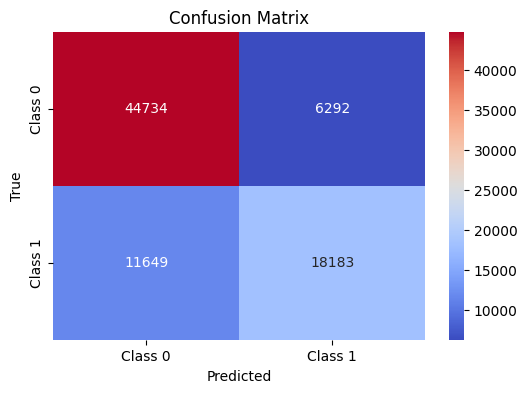

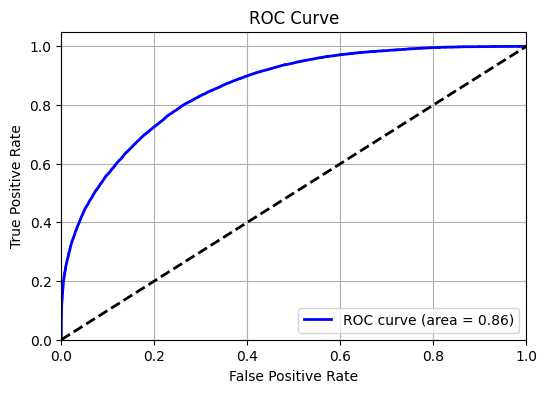

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.79      0.88      0.83     51026
     Class 1       0.74      0.61      0.67     29832

    accuracy                           0.78     80858
   macro avg       0.77      0.74      0.75     80858
weighted avg       0.77      0.78      0.77     80858



In [27]:
#Evaluate the model
evaluate_binary_model(xgb_clf, "XGBXlassifier using Word2Vec", X_train, y_train, X_test, y_test)

**Inferences:**

The XGBoost classifier using Word2Vec embeddings demonstrates a clear performance enhancement compared to previous models, achieving a higher test set accuracy of 77.8% and a ROC AUC of 0.857. The model's F1 score of 0.6696 reflects a better balance between precision (0.7429) and recall (0.6095), surpassing the Logistic Regression with TF-IDF and initial XGBoost models with TF-IDF in effectively identifying duplicate questions. This improvement underscores the effectiveness of Word2Vec in capturing semantic relationships, making it a strong foundation for further exploration with more advanced embeddings like BERT and advanced Network like Siamese Network.

### **Siamese Network**

Siamese Networks represent a specialized neural network architecture tailored for comparing and capturing the relationships between pairs of input data. This architecture is particularly well-suited for tasks involving similarity analysis. In this implementation, we leverage a Siamese Network to assess text similarity, effectively quantifying the semantic closeness between two input questions.

Basic Siamese Network is like this:

![Image](https://miro.medium.com/v2/resize:fit:750/format:webp/0*5lncKE9W56R9_HDH.jpg)

#### **Siamese LSTM**

The Siamese LSTM architecture is particularly well-suited for the task of determining semantic similarity between question pairs in this project. By sharing the same weights across both input sequences, the Siamese network ensures that it learns a unified representation for both questions, making it easier to compare their underlying semantics. The LSTM layers effectively capture the sequential nature of text, which is crucial for understanding context and meaning. The network's ability to compute a similarity score based on the distance between two LSTM outputs makes it an effective tool for identifying whether two questions have the same intent, thereby improving the accuracy of duplicate question detection.

In [12]:
#Extract questions and labels
questions1 = train_quora_data['question1_processed']
questions2 = train_quora_data['question2_processed']
labels = train_quora_data['is_duplicate']

In [13]:
#Split the data into training and testing sets before tokenization to prevent data leakage
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(questions1, questions2, labels, test_size=0.2, random_state=42)

In [14]:
#Tokenize your questions
max_sequence_length = 80
embedding_dim = 300

#Combine the training questions for tokenizer fitting
questions_train = pd.concat([X_train1, X_train2])

#Initialize the tokenizer and fit it on the training data only
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions_train)

#Tokenize and pad the sequences for training data
sequences1_train = tokenizer.texts_to_sequences(X_train1)
sequences2_train = tokenizer.texts_to_sequences(X_train2)
padded_sequences1_train = pad_sequences(sequences1_train, maxlen=max_sequence_length)
padded_sequences2_train = pad_sequences(sequences2_train, maxlen=max_sequence_length)

#Tokenize and pad the sequences for test data
sequences1_test = tokenizer.texts_to_sequences(X_test1)
sequences2_test = tokenizer.texts_to_sequences(X_test2)
padded_sequences1_test = pad_sequences(sequences1_test, maxlen=max_sequence_length)
padded_sequences2_test = pad_sequences(sequences2_test, maxlen=max_sequence_length)

tokens = [word for sentence in questions for word in sentence.split()]
vocabulary_size = len(set(tokens))

I preprocessed the text data by setting a maximum sequence length of 80 and an embedding dimension of 300. The tokenizer was fitted on the combined training questions to learn the vocabulary, ensuring no data leakage from the test set. I then tokenized and padded the sequences for both training and test data, standardizing input lengths for the model. The vocabulary size was calculated from the unique tokens in the dataset, preparing the data for embedding and model training.

```
Input 1  ────────────────────────────┐
          Word2Vec Embeddings        │
                                     ▼
                               LSTM Layer
                                     │
                                     ▼
                             Output Vector 1
                                     │
                                     └─────────┐
                                               │
                                               ▼
                                               Distance Layer ──────► Same or Different Class
                                               ▲
                                               │
                                     ┌─────────┘
                                     │
                             Output Vector 2
                                     │
                                LSTM Layer
                                     │
          Word2Vec Embeddings        ▲
Input 2  ────────────────────────────┘

```



In [16]:
#Defining the Siamese Network
input_layer1 = Input(shape=(max_sequence_length,))
input_layer2 = Input(shape=(max_sequence_length,))

#Embedding layer that converts word indices to dense vectors of a fixed size
embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)

#LSTM layer
lstm_layer = LSTM(units=50)

#Apply the embedding layer and LSTM to the first input
x1 = embedding_layer(input_layer1)
x1 = lstm_layer(x1)

#Apply the embedding layer and LSTM to the second input
x2 = embedding_layer(input_layer2)
x2 = lstm_layer(x2)

#Lambda layer to compute the absolute difference between the two LSTM outputs, representing the "distance" between the two sequences
distance_layer = Lambda(lambda x: tf.keras.backend.abs(x[0] - x[1]))([x1, x2])

#Output layer with a sigmoid activation to produce a probability score (0 to 1) indicating whether the two questions are duplicates
output_layer = Dense(units=1, activation='sigmoid')(distance_layer)

#Compile the Siamese Network with binary cross-entropy loss and accuracy as the evaluation metric
siamese_model = Model(inputs=[input_layer1, input_layer2], outputs=output_layer)
siamese_model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

#Callbacks for early stopping to prevent overfitting and for saving the best model weights
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint(filepath='siamese_model_weights.keras', save_best_only=True)
]

In [17]:
#Train the model on the training data and validating on validation data (0.2 of training data)
siamese_model.fit([padded_sequences1_train, padded_sequences2_train], y_train,
                  epochs=5, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/5
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 267s 32ms/step - accuracy: 0.6360 - loss: 0.6174 - val_accuracy: 0.7470 - val_loss: 0.5400
Epoch 2/5
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 354s 37ms/step - accuracy: 0.7680 - loss: 0.4957 - val_accuracy: 0.7693 - val_loss: 0.4907
Epoch 3/5
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 279s 34ms/step - accuracy: 0.8094 - loss: 0.4233 - val_accuracy: 0.7813 - val_loss: 0.4717
Epoch 4/5
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 283s 30ms/step - accuracy: 0.8332 - loss: 0.3750 - val_accuracy: 0.7856 - val_loss: 0.4650
Epoch 5/5
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 253s 29ms/step - accuracy: 0.8554 - loss: 0.3343 - val_accuracy: 0.7884 - val_loss: 0.4616


In [19]:
def evaluate_binary_model(model, model_name, X_train1, X_train2, y_train, X_test1, X_test2, y_test):
    def calculate_metrics(predictions, probabilities, y_true):
        """
        Calculate key evaluation metrics for a binary classification model.

        Args:
        - predictions (array-like): Predicted class labels.
        - probabilities (array-like): Predicted probabilities for the positive class.
        - y_true (array-like): True class labels.

        Returns:
        - accuracy (float): Accuracy of the model.
        - precision (float): Precision of the model.
        - recall (float): Recall of the model.
        - f1 (float): F1 score of the model.
        - roc_auc (float): ROC AUC score of the model.
        """

        accuracy = accuracy_score(y_true, predictions)
        precision = precision_score(y_true, predictions)
        recall = recall_score(y_true, predictions)
        f1 = f1_score(y_true, predictions)
        roc_auc = roc_auc_score(y_true, probabilities)
        return accuracy, precision, recall, f1, roc_auc

    def print_metrics(accuracy, precision, recall, f1, roc_auc, dataset_name):
        """
        Print evaluation metrics for a specific dataset (train/test).

        Args:
        - accuracy (float): Accuracy of the model.
        - precision (float): Precision of the model.
        - recall (float): Recall of the model.
        - f1 (float): F1 score of the model.
        - roc_auc (float): ROC AUC score of the model.
        - dataset_name (str): The name of the dataset (e.g., "Train", "Test").
        """

        print(f"\n{dataset_name} Set Metrics:")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("ROC AUC:", roc_auc)

    def plot_confusion_matrix(y_true, predictions):
        """
        Plot the confusion matrix as a heatmap.

        Args:
        - y_true (array-like): True class labels.
        - predictions (array-like): Predicted class labels.
        """

        conf_matrix = confusion_matrix(y_true, predictions)
        plt.figure(figsize=(7, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
                    xticklabels=['Class 0', 'Class 1'],
                    yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def plot_roc_curve(y_true, probabilities):
        """
        Plot the ROC curve and calculate the AUC score.

        Args:
        - y_true (array-like): True class labels.
        - probabilities (array-like): Predicted probabilities for the positive class.
        """

        fpr, tpr, _ = roc_curve(y_true, probabilities)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def print_classification_report(y_true, predictions):
        """
        Print a detailed classification report, including precision, recall, and F1 score.

        Args:
        - y_true (array-like): True class labels.
        - predictions (array-like): Predicted class labels.
        """
        class_report = classification_report(y_true, predictions,
                                             target_names=['Class 0', 'Class 1'])
        print("Classification Report:\n", class_report)

    # Print model name
    print("--- Results of", model_name, "---")

    #Training set evaluation
    train_probabilities = model.predict([X_train1, X_train2]).ravel()
    train_predictions = (train_probabilities > 0.5).astype(int)
    train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = calculate_metrics(train_predictions, train_probabilities, y_train)
    print_metrics(train_accuracy, train_precision, train_recall, train_f1, train_roc_auc, "Train")

    #Test set evaluation
    test_probabilities = model.predict([X_test1, X_test2]).ravel()
    test_predictions = (test_probabilities > 0.5).astype(int)
    test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = calculate_metrics(test_predictions, test_probabilities, y_test)
    print_metrics(test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, "Test")

    #Plotting and printing
    plot_confusion_matrix(y_test, test_predictions)
    plot_roc_curve(y_test, test_probabilities)
    print_classification_report(y_test, test_predictions)

--- Results of Siamese Network ---
10108/10108 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step

Train Set Metrics:
Accuracy: 0.8601547789468477
Precision: 0.8037364814526758
Recall: 0.8220143848749487
F1 Score: 0.812772686254543
ROC AUC: 0.9306407054011567
2527/2527 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step

Test Set Metrics:
Accuracy: 0.7925870043780454
Precision: 0.7083027654620268
Recall: 0.7443684633950121
F1 Score: 0.7258879100403708
ROC AUC: 0.8606072210259421


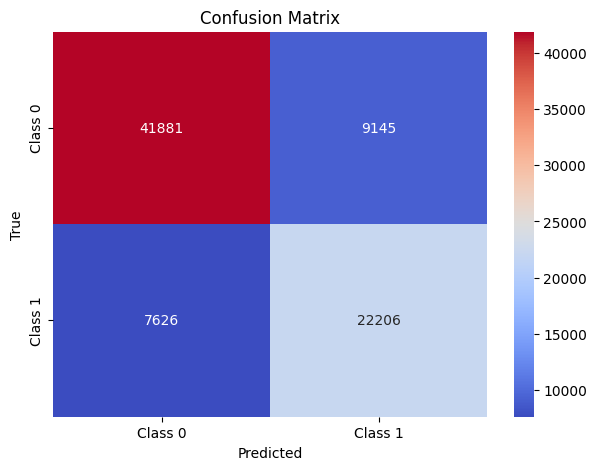

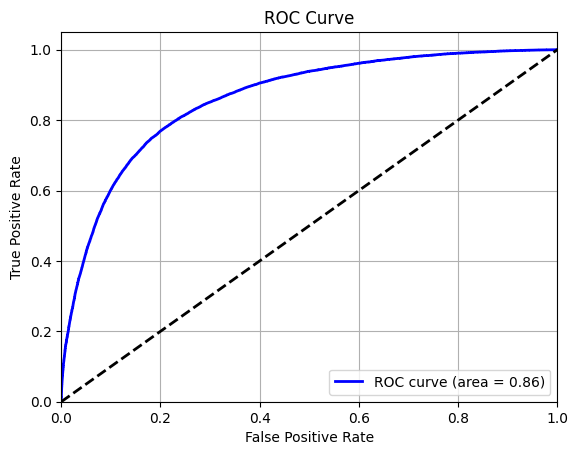

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.85      0.82      0.83     51026
     Class 1       0.71      0.74      0.73     29832

    accuracy                           0.79     80858
   macro avg       0.78      0.78      0.78     80858
weighted avg       0.80      0.79      0.79     80858



In [22]:
#Evaluating the model
evaluate_binary_model(siamese_model, "Siamese LSTM Network", padded_sequences1_train, padded_sequences2_train, y_train, padded_sequences1_test, padded_sequences2_test, y_test)

**Inferences:**

Siamese LSTM network has shown a significant improvement in performance over the previous models, including the XGBoost classifier with Word2Vec embeddings. With a test set accuracy of 79.26% and a ROC AUC of 0.86, this model better captures the subtle semantic similarities between questions. The F1 score of 0.7259 indicates a balanced handling of precision (0.7083) and recall (0.7444), especially in identifying duplicate questions. Compared to the XGBoost model, the Siamese LSTM demonstrates its ability to more effectively understand and compare the sequential nature of text data, making it a superior choice for this task. This model's architecture, which focuses on the differences between LSTM-encoded question embeddings, provides a more nuanced understanding of text similarity, making it a promising approach for further refinement in detecting semantic duplication.

#### **Siamese BERT**

Siamese BERT is particularly useful for the Quora Question Pairs problem as it leverages the power of BERTs contextual embeddings while maintaining the twin network structure of a Siamese architecture. This allows the model to generate rich, context-aware representations of each question independently. By using shared weights between the two BERT models, Siamese BERT ensures that both questions are embedded in the same feature space, enabling an effective comparison of their semantic similarities. This architecture is well-suited for identifying duplicate questions, as it captures the nuanced meaning of each question pair and measures their similarity through a learned distance function, making it a powerful tool for this task.

In [23]:
#Set up logging for transformers
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()

#Checking for available TPU or GPU so that the model can be trained faster
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [24]:
#Extracting X (input features to model) and y (label)
X = train_quora_data[['question1', 'question2']]
y = train_quora_data['is_duplicate']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
#Extracting questions from X_train and X_test
questions1_train = X_train['question1'].astype(str)
questions2_train = X_train['question2'].astype(str)

questions1_test = X_test['question1'].astype(str)
questions2_test = X_test['question2'].astype(str)

In [26]:
#Loading the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
bert_model.trainable = False

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

I chose to use the "bert-base-uncased" model because of its ability to generate rich contextual embeddings, which are essential for capturing the semantic nuances in text. The "uncased" version is particularly effective in this context since the distinction between uppercase and lowercase letters isn't crucial for identifying duplicate questions. By leveraging the pre-trained "bert-base-uncased" model, I can take advantage of the extensive training BERT has undergone on a vast corpus, which enhances its ability to understand and differentiate the meanings and relationships between words in the input questions. I've also decided to freeze the BERT model during initial training to preserve its learned representations while reducing computational demands, allowing the model to concentrate on the task-specific layers.

In [27]:
#Lists to store individual question pair input ids and masks for training data
input_ids_1_train = []
attention_masks_1_train = []
input_ids_2_train = []
attention_masks_2_train = []

#Lists to store individual question pair input ids and masks for testing data
input_ids_1_test = []
attention_masks_1_test = []
input_ids_2_test = []
attention_masks_2_test = []

#Loop through each pair of questions in training data
for i, (q1, q2) in enumerate(zip(questions1_train, questions2_train)):
    encoding_1 = tokenizer.encode_plus(
        q1,
        q2,
        add_special_tokens=True,
        max_length=50,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors="tf",
    )

    encoding_2 = tokenizer.encode_plus(
        q2,
        q1,
        add_special_tokens=True,
        max_length=50,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors="tf",
    )

    #Append input ids and attention masks to respective lists
    input_ids_1_train.append(encoding_1["input_ids"])
    attention_masks_1_train.append(encoding_1["attention_mask"])

    input_ids_2_train.append(encoding_2["input_ids"])
    attention_masks_2_train.append(encoding_2["attention_mask"])

#Convert the lists to numpy arrays
input_ids_1_train = np.array(input_ids_1_train)
attention_masks_1_train = np.array(attention_masks_1_train)
input_ids_2_train = np.array(input_ids_2_train)
attention_masks_2_train = np.array(attention_masks_2_train)


#Loop through each pair of questions in training data
for i, (q1, q2) in enumerate(zip(questions1_test, questions2_test)):
    encoding_1 = tokenizer.encode_plus(
        q1,
        q2,
        add_special_tokens=True,
        max_length=80,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors="tf",
    )
    encoding_2 = tokenizer.encode_plus(
        q2,
        q1,
        add_special_tokens=True,
        max_length=50,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors="tf",
    )

    #Append input ids and attention masks to respective lists
    input_ids_1_test.append(encoding_1["input_ids"])
    attention_masks_1_test.append(encoding_1["attention_mask"])

    input_ids_2_test.append(encoding_2["input_ids"])
    attention_masks_2_test.append(encoding_2["attention_mask"])

#Convert the lists to numpy arrays
input_ids_1_test = np.array(input_ids_1_test)
attention_masks_1_test = np.array(attention_masks_1_test)
input_ids_2_test = np.array(input_ids_2_test)
attention_masks_2_test = np.array(attention_masks_2_test)

In [ ]:
#Attempting to initialize the TPU system, if available. If TPU is not available, fall back to default strategy (CPU/GPU).
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

except ValueError:
    tpu_strategy = tf.distribute.get_strategy()

In [33]:
#Custom layer to calculate L1 distance between two embeddings
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, embedding1, embedding2):
        #Calculate the absolute difference between two embedding vectors (L1 distance)
        return tf.math.abs(embedding1 - embedding2)

with tpu_strategy.scope():
    #Load the pre-trained BERT model and tokenizer
    transformer_model = TFBertModel.from_pretrained("bert-base-uncased")

    #Defining input layers for two questions
    input_ids_in1 = Input(shape=(None,),name='input_ids1', dtype='int32')
    input_masks_in1 = Input(shape=(None,), name='attention_mask1', dtype='int32')
    input_ids_in2 = Input(shape=(None,),name='input_ids2', dtype='int32')
    input_masks_in2 = Input(shape=(None,), name='attention_mask2', dtype='int32')

    #Generating embeddings for both questions using the BERT model
    embedding_layer1 = transformer_model(input_ids_in1, attention_mask=input_masks_in1).last_hidden_state
    embedding_layer2 = transformer_model(input_ids_in2, attention_mask=input_masks_in2).last_hidden_state

    #Applying global average pooling to reduce the dimensionality of the embeddings
    embedding1 = GlobalAveragePooling1D()(embedding_layer1)
    embedding2 = GlobalAveragePooling1D()(embedding_layer2)

    #Computing the L1 distance between the two pooled embeddings
    l1_dist = L1Dist()(embedding1,embedding2)

    #Adding a dense layer with ReLU activation for learning higher-level features
    x = Dense(512, activation='relu')(l1_dist)
    x = Dropout(0.3)(x)

    #Final output layer with a sigmoid activation to predict the similarity between the two inputs
    output = Dense(1, activation='sigmoid')(x)

    #Compiling the model using binary crossentropy loss and the Adam optimizer
    model = Model(inputs=[input_ids_in1, input_masks_in1, input_ids_in2, input_masks_in2], outputs = output)
    model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),metrics='accuracy')

#Freezing the first few layers of the model (especially the BERT layers) to avoid overfitting and reduce computational load
for layer in model.layers[:5]:
  layer.trainable = False

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=1e-7)

```
Input 1  ────────────────────────────┐
          BERT Embeddings            │
                                     ▼
                       Global Average Pooling Layer
                                     │
                                     ▼
                             Embedding Vector 1
                                     │
                                     └─────────┐
                                               │
                                               ▼
                                       L1 Distance Layer ──────► Same or Different Class
                                               ▲
                                               │
                                     ┌─────────┘
                                     │
                             Embedding Vector 2
                                     │
                       Global Average Pooling Layer
                                     │
          BERT Embeddings            ▲
Input 2  ────────────────────────────┘
```



In [ ]:
#Converting labels to integers, ensuring the labels are in the correct format for training
labels_train = y_train.astype(int)
label_test = y_test.astype(int)

#Train the model using the training data
history = model.fit(
    x=[
        input_ids_1_train[:, 0], #Input ID for the first question in training data
        attention_masks_1_train[:, 0], #Attention mask for the first question in training data
        input_ids_2_train[:, 0], #Input ID for the second question in training data
        attention_masks_2_train[:, 0] #Attention mask for the second question in training data
    ],
    y=labels_train,
    epochs=5,
    batch_size=32,
    validation_data=(
        (
            np.asarray(input_ids_1_test[:, 0]), #Input ID for the first question in test data
            np.asarray(attention_masks_1_test[:, 0]), #Attention mask for the first question in test data
            np.asarray(input_ids_2_test[:, 0]), #Input ID for the second question in test data
            np.asarray(attention_masks_2_test[:, 0])) #Attention mask for the second question in test data
        ,
        label_test
    ),callbacks =[earlystopping, learning_rate_reduction] #Callbacks for early stopping and learning rate reduction
)

Epoch 1/5
10108/10108 [==============================] - 7448s 731ms/step - loss: 0.3725 - accuracy: 0.8224 - val_loss: 0.3070 - val_accuracy: 0.8728 - lr: 1.0000e-05
Epoch 2/5
10108/10108 [==============================] - 7370s 729ms/step - loss: 0.2693 - accuracy: 0.8860 - val_loss: 0.2839 - val_accuracy: 0.8823 - lr: 1.0000e-05
Epoch 3/5
10108/10108 [==============================] - 7362s 728ms/step - loss: 0.2214 - accuracy: 0.9099 - val_loss: 0.2497 - val_accuracy: 0.8981 - lr: 1.0000e-05
Epoch 4/5
10108/10108 [==============================] - 7372s 729ms/step - loss: 0.1786 - accuracy: 0.9302 - val_loss: 0.2599 - val_accuracy: 0.9023 - lr: 1.0000e-05
Epoch 5/5
10108/10108 [==============================] - 7378s 730ms/step - loss: 0.1406 - accuracy: 0.9473 - val_loss: 0.2714 - val_accuracy: 0.9069 - lr: 1.0000e-05


In [ ]:
def evaluate_binary_model(model, model_name, X_test_ids1, X_test_masks1, X_test_ids2, X_test_masks2, y_test):
    def calculate_metrics(predictions, probabilities, y_true):
        """
        Calculate key evaluation metrics for a binary classification model.

        Args:
        - predictions (array-like): Predicted class labels.
        - probabilities (array-like): Predicted probabilities for the positive class.
        - y_true (array-like): True class labels.

        Returns:
        - accuracy (float): Accuracy of the model.
        - precision (float): Precision of the model.
        - recall (float): Recall of the model.
        - f1 (float): F1 score of the model.
        - roc_auc (float): ROC AUC score of the model.
        """

        accuracy = accuracy_score(y_true, predictions)
        precision = precision_score(y_true, predictions)
        recall = recall_score(y_true, predictions)
        f1 = f1_score(y_true, predictions)
        roc_auc = roc_auc_score(y_true, probabilities)
        return accuracy, precision, recall, f1, roc_auc

    def print_metrics(accuracy, precision, recall, f1, roc_auc, dataset_name):
        """
        Print evaluation metrics for a specific dataset (train/test).

        Args:
        - accuracy (float): Accuracy of the model.
        - precision (float): Precision of the model.
        - recall (float): Recall of the model.
        - f1 (float): F1 score of the model.
        - roc_auc (float): ROC AUC score of the model.
        - dataset_name (str): The name of the dataset (e.g., "Train", "Test").
        """

        print(f"\n{dataset_name} Set Metrics:")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("ROC AUC:", roc_auc)

    def plot_confusion_matrix(y_true, predictions):
        """
        Plot the confusion matrix as a heatmap.

        Args:
        - y_true (array-like): True class labels.
        - predictions (array-like): Predicted class labels.
        """
        conf_matrix = confusion_matrix(y_true, predictions)
        plt.figure(figsize=(7, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
                    xticklabels=['Class 0', 'Class 1'],
                    yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def plot_roc_curve(y_true, probabilities):
        """
        Plot the ROC curve and calculate the AUC score.

        Args:
        - y_true (array-like): True class labels.
        - probabilities (array-like): Predicted probabilities for the positive class.
        """
        fpr, tpr, _ = roc_curve(y_true, probabilities)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def print_classification_report(y_true, predictions):
        """
        Print a detailed classification report, including precision, recall, and F1 score.

        Args:
        - y_true (array-like): True class labels.
        - predictions (array-like): Predicted class labels.
        """

        class_report = classification_report(y_true, predictions, target_names=['Class 0', 'Class 1'])
        print("Classification Report:\n", class_report)

    print("--- Results of", model_name, "---")

    #Test set evaluation
    test_probabilities = model.predict([X_test_ids1, X_test_masks1, X_test_ids2, X_test_masks2]).ravel()
    test_predictions = (test_probabilities > 0.5).astype(int)
    test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = calculate_metrics(test_predictions, test_probabilities, y_test)
    print_metrics(test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, "Test")

    #Plotting and printing
    plot_confusion_matrix(y_test, test_predictions)
    plot_roc_curve(y_test, test_probabilities)
    print_classification_report(y_test, test_predictions)

--- Results of BERT-based Siamese Network ---
2527/2527 [==============================] - 726s 285ms/step

Test Set Metrics:
Accuracy: 0.9069356155235103
Precision: 0.8661086492696537
Recall: 0.8844864574953071
F1 Score: 0.8752010879479908
ROC AUC: 0.9633247391312516


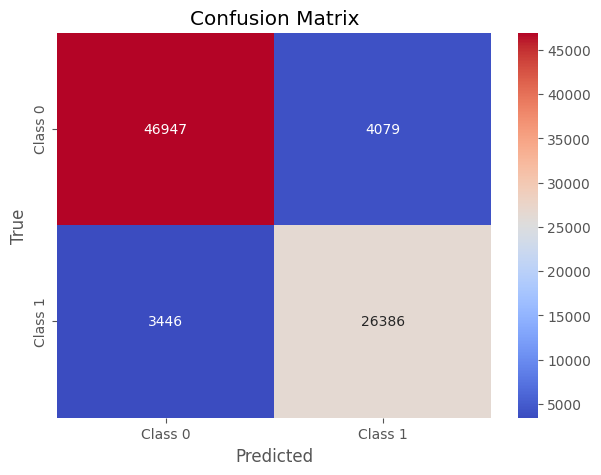

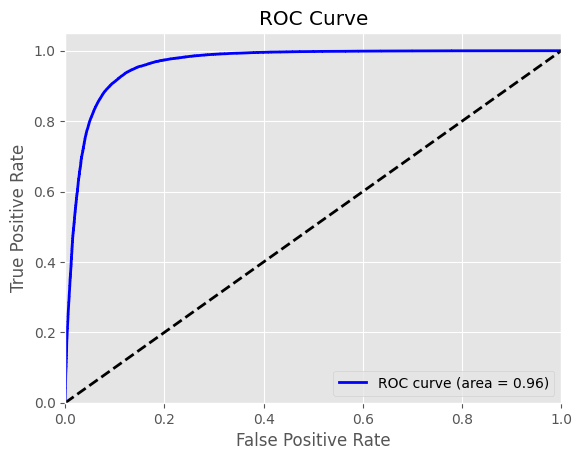

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.92      0.93     51026
     Class 1       0.87      0.88      0.88     29832

    accuracy                           0.91     80858
   macro avg       0.90      0.90      0.90     80858
weighted avg       0.91      0.91      0.91     80858



In [ ]:
#Evaluate the model
evaluate_binary_model(
    model,
    "BERT-based Siamese Network",
    input_ids_1_test[:, 0], attention_masks_1_test[:, 0], input_ids_2_test[:, 0], attention_masks_2_test[:, 0], y_test
)

**Inferences:**

BERT-based Siamese Network significantly outperforms all previously tested models, including the Siamese LSTM and XGBoost with Word2Vec embeddings. This model achieves a test accuracy of 90.69% and an outstanding ROC AUC of 0.96, indicating a high capability in distinguishing between duplicate and non-duplicate questions. The F1 score of 0.875 further reflects a well-balanced precision (0.866) and recall (0.884), demonstrating that the model effectively captures the nuanced semantic relationships between question pairs. Compared to the Siamese LSTM, which also showed strong performance, the BERT-based model provides a more sophisticated understanding of language context and nuances, leading to more accurate predictions. This underscores the strength of pre-trained transformer models in complex NLP tasks, making the BERT-based Siamese Network the most promising approach for the Quora question pairs problem.